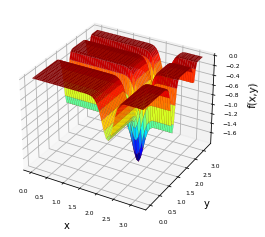

In [14]:
# michalewicz_graph.py

from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(0, 3.2, 50)    
Y = np.linspace(0, 3.2, 50)    
X, Y = np.meshgrid(X, Y)

# Michalewicz function
Z = -1 * ( (np.sin(X) * np.sin((1 * X**2) / np.pi)**20) + \
           (np.sin(Y) * np.sin((2 * Y**2) / np.pi)**20) )

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, \
  rstride=1, cstride=1, cmap=cm.jet, \
  edgecolor='darkred', linewidth=0.1)

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)
ax.set_zlabel('f(x,y)', fontsize=10)
ax.tick_params(axis='both', which='major',
  labelsize=6)
    
plt.show()

Nelder Mead Function

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi

In [16]:
def func(v): 
   return -1 * ( (np.sin(v[0]) * np.sin((1 * v[0]**2) / np.pi)**20) + \
            (np.sin(v[1]) * np.sin((2 * v[1]**2) / np.pi)**20))
    

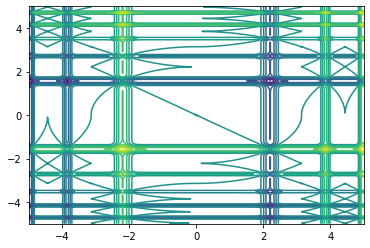

In [17]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))

Z = func([X,Y])

plt.contour(X, Y, Z, levels = 20)
plt.show()

In [18]:
def i_trg(x, y, c):
    x1 = x + c
    y1 = y
    x2 = x + c/2
    y2 = y + (c/2)*(3**(1/2))
    return list(zip(np.array([x,x1,x2]), np.array([y,y1,y2])))

In [19]:
def BGW(V, f):
    T = [(V[i], f(V[i])) for i in range(len(V)) ]
    return sorted(T, key=itemgetter(1))

    # alternatively, equivalent:
    #return sorted(T, key=lambda column: column[1]) 

In [20]:
def midpoint(o_trg, A=0, B=1):
    return ((o_trg[A][0][0] + o_trg[B][0][0])/2,
            (o_trg[A][0][1] + o_trg[B][0][1])/2)

def reflection(o_trg):
    M = midpoint(o_trg)
    W = o_trg[2][0]
    return (2*M[0] - W[0], 2*M[1] - W[1])

def expansion(o_trg):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    return (2*R[0] - M[0], 2*R[1] - M[1])

def contraction(o_trg, f):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    W = o_trg[2][0]
    insC = ((W[0] + M[0])/2, (W[1] + M[1])/2)
    outC = ((R[0] + M[0])/2, (R[1] + M[1])/2)
    return (insC, outC)

def shrink(o_trg, f):
    M, S  = midpoint(o_trg), midpoint(o_trg, A=0, B=2)
    return M, S

In [21]:
def nelder_mead(o_trg, f, iterations, plot=False):
    print("k \t {:^20}   \t {:^20}   \t {:^20}".format("Best point", "Good point", "Worst point"))
     
    for i in range(iterations):
        
        if (i == 0):     
            print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
                    .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                            o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                            o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))

            if plot:
                bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
                plt.clf()
                plt.contour(X, Y, Z, levels = 50)
                plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
                plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
                plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
                plt.plot(bgw[0,0], bgw[0,1], '.r')
                plt.show(block=False)
                plt.pause(0.1)
        
        
        R = reflection(o_trg)
        G = o_trg[1][0]
        B = o_trg[0][0]
        
        if f(R) < f(G):
            # Case 1: reflection found a better point than Good point

            if f(B) < f(R):
                # Case 1a: reflected point is not better than Best point -> replace Worst with R and end this iteration
                
                o_trg = BGW([B, G, R], f)              
            else:
                # Case 1b: reflected point is better than Best point -> go even further (expansion)
                
                E = expansion(o_trg)
                if f(E) < f(R):
                    # Case 1ba: expanded point is better than reflected point -> replace Worst with E and end this iteration
                    o_trg = BGW([B, G, E], f)
                else:
                    # Case 1bb: expanded point is not better than reflected point -> replace Worst with R and end this iteration
                    o_trg = BGW([B, G, R], f)
        else:
            # Case 2: reflection found a worse point than Good point

            W = o_trg[2][0]
            if f(R) > f(W):
                # Case 2a: reflected point is worse than Worst point -> perform inside contraction
                C = contraction(o_trg, f)[0]
            else:
                # Case 2b: reflected point is not worse than Worst point -> perform outside contraction
                C = contraction(o_trg, f)[1]

            if f(C) < f(W):
                # Case 3a: contraction worked -> replace Worst with C and end this iteration
                o_trg = BGW([B, G, C], f)
            else:
                # Case 3b: contraction did not work -> shrink the triangle
                M, S = shrink(o_trg, f)
                o_trg = BGW([B, M, S], f)
         
        print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
              .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                      o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                      o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))
        
        if plot:
            bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
            plt.clf()
            plt.contour(X, Y, Z, levels = 50)
            plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
            plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
            plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
            plt.plot(bgw[0,0], bgw[0,1], '.r')
            plt.show(block=False)
            plt.pause(0.1)
            
    plt.show()
                
    return o_trg

In [22]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))
v_func = np.vectorize(func)
Z = func([X,Y])

In [23]:
trg = i_trg(2,3,5)
trg

[(2.0, 3.0), (7.0, 3.0), (4.5, 7.330127018922193)]

In [24]:
o_trg = BGW(trg,func)
o_trg

[((2.0, 3.0), -0.37014331283611873),
 ((7.0, 3.0), -3.6755801116197824e-07),
 ((4.5, 7.330127018922193), -4.734479529853247e-10)]

k 	      Best point        	      Good point        	     Worst point     
1 	 f(2.00,3.00) = -0.37   	 f(7.00,3.00) = -0.00   	 f(4.50,7.33) = -0.00


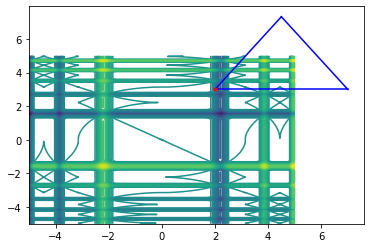

1 	 f(2.00,3.00) = -0.37   	 f(4.50,3.00) = -0.00   	 f(3.25,5.17) = 0.37


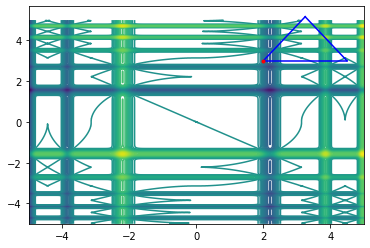

2 	 f(2.00,3.00) = -0.37   	 f(3.25,1.92) = -0.00   	 f(4.50,3.00) = -0.00


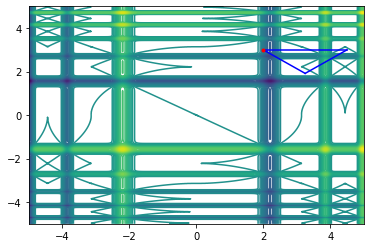

3 	 f(2.00,3.00) = -0.37   	 f(0.75,1.92) = -0.00   	 f(3.25,1.92) = -0.00


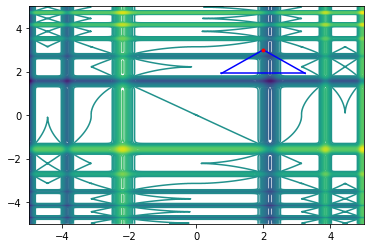

4 	 f(2.31,2.19) = -0.62   	 f(2.00,3.00) = -0.37   	 f(0.75,1.92) = -0.00


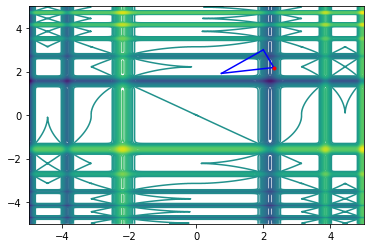

5 	 f(2.16,2.59) = -0.85   	 f(2.31,2.19) = -0.62   	 f(1.53,2.05) = -0.00


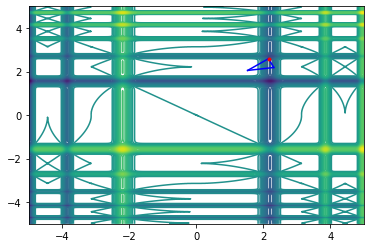

6 	 f(2.16,2.59) = -0.85   	 f(2.31,2.19) = -0.62   	 f(2.59,2.56) = -0.05


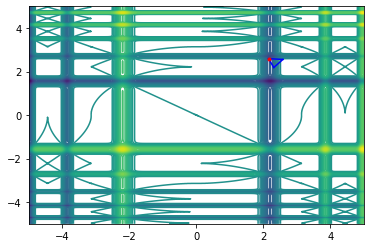

7 	 f(2.16,2.59) = -0.85   	 f(2.31,2.19) = -0.62   	 f(2.06,2.31) = -0.54


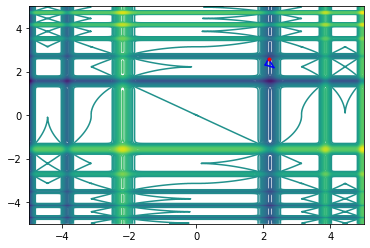

8 	 f(2.16,2.59) = -0.85   	 f(2.15,2.35) = -0.75   	 f(2.31,2.19) = -0.62


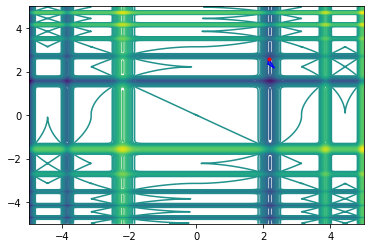

9 	 f(2.16,2.59) = -0.85   	 f(2.15,2.35) = -0.75   	 f(2.07,2.61) = -0.70


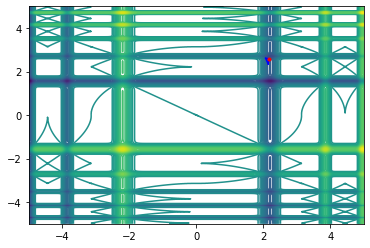

10 	 f(2.16,2.59) = -0.85   	 f(2.23,2.33) = -0.79   	 f(2.15,2.35) = -0.75


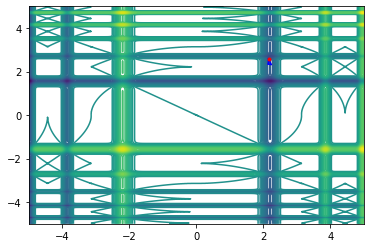

11 	 f(2.16,2.59) = -0.85   	 f(2.24,2.58) = -0.82   	 f(2.23,2.33) = -0.79


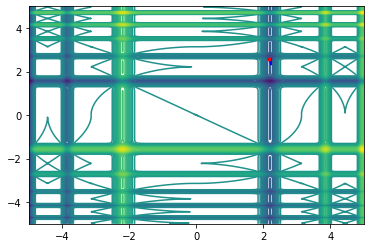

12 	 f(2.16,2.59) = -0.85   	 f(2.17,2.84) = -0.83   	 f(2.24,2.58) = -0.82


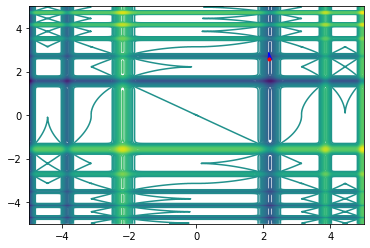

13 	 f(2.20,2.65) = -1.05   	 f(2.16,2.59) = -0.85   	 f(2.17,2.84) = -0.83


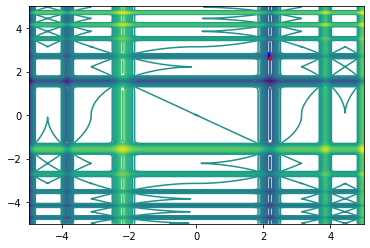

14 	 f(2.17,2.73) = -1.18   	 f(2.20,2.65) = -1.05   	 f(2.16,2.59) = -0.85


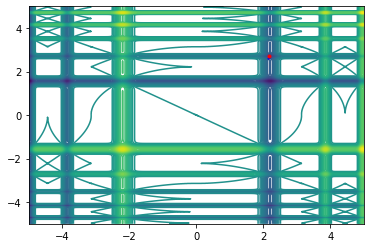

15 	 f(2.20,2.73) = -1.19   	 f(2.17,2.73) = -1.18   	 f(2.20,2.65) = -1.05


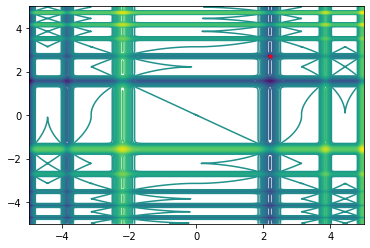

16 	 f(2.19,2.69) = -1.19   	 f(2.20,2.73) = -1.19   	 f(2.17,2.73) = -1.18


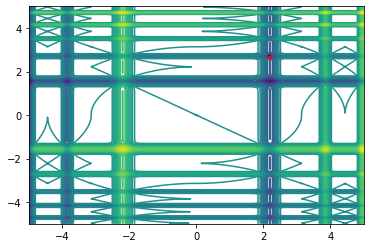

17 	 f(2.22,2.69) = -1.19   	 f(2.19,2.69) = -1.19   	 f(2.20,2.73) = -1.19


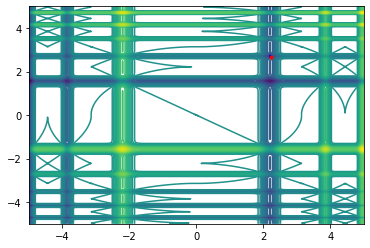

18 	 f(2.21,2.71) = -1.21   	 f(2.22,2.69) = -1.19   	 f(2.19,2.69) = -1.19


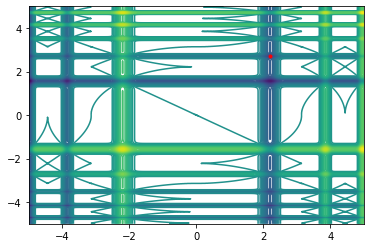

19 	 f(2.21,2.71) = -1.21   	 f(2.24,2.72) = -1.19   	 f(2.22,2.69) = -1.19


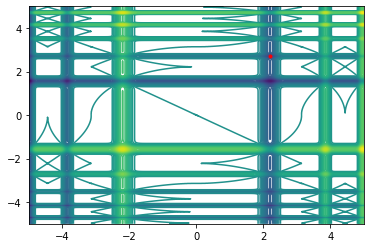

20 	 f(2.21,2.71) = -1.21   	 f(2.22,2.70) = -1.21   	 f(2.24,2.72) = -1.19


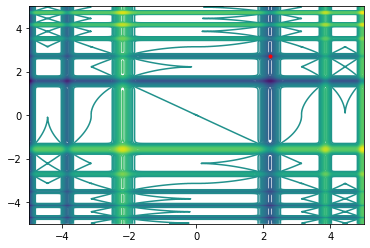

[((2.2057743072509766, 2.7130223779173095), -1.2138197408971951),
 ((2.22244930267334, 2.704717891227692), -1.2054727939020498),
 ((2.235605239868164, 2.717977815026977), -1.1945566340153893)]

In [25]:
nelder_mead(o_trg,func,20,plot=True)

Is this the python based algorithm? 

PSO found best solution at f([4.22388066 1.68055975])=-0.590526123895102
Global optimal at f([2.2222222222222223, 1.5656565656565655])=-1.794144469027823


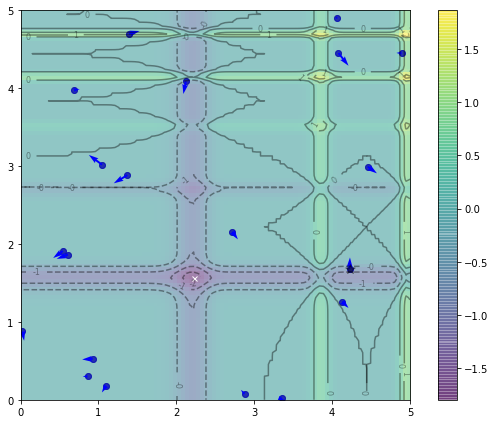

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
 
def f(x,y):
    "Objective function"
    return -1 * ( (np.sin(x) * np.sin((1 * x**2) / np.pi)**20) + \
           (np.sin(y) * np.sin((2 * y**2) / np.pi)**20) )
    
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
 
# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
 
# Hyper-parameter of the algorithm
c1 = c2 = 0.1
w = 0.8
 
# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1
 
# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()
 
def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
 
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
 
def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot
 
anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
#anim.save("PSO.gif", dpi=120, writer="imagemagick")
 
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))